[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/sign_detector.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

In [1]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone
if colab == True:
    dataset_path = '.'
else:
    dataset_path = 'data'

In [ ]:
import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pycocotools.coco import COCO
import fiftyone as fo
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
import cv2

## Обучение модели

In [2]:
import os
import json
#import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pycocotools.coco import COCO
import fiftyone as fo
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
#import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
import cv2
#PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

In [ ]:
#from PIL import Image
#img = Image.open('data/rtsd-frames/autosave01_02_2012_09_16_49.jpg').convert("RGB")
#img

### Загрузчик данных

In [3]:
# Преобразование классов знаков в 1 класс
def anno_to_bin_class(anno_file):
    '''Функция создает копию файла с аннотацией, преобразует все классы в 1 (знак)
    и сохраняет новый файл с аннотацией'''
    with open(os.path.join(dataset_path, anno_file), 'r') as read_file:
        anno_json = json.load(read_file)
    read_file.close()

    for i in range(len(anno_json['annotations'])):
        anno_json['annotations'][i]['category_id'] = 1    
    
    anno_json['categories'] = [{'id': 1, 'name': 'sign'}]
    
    anno_file_new = anno_file.split('.')[0] + '_bin_class.json'
    
    with open(os.path.join(dataset_path, anno_file_new), 'w') as f:
        json.dump(anno_json, f)#ensure_ascii=False, indent=4)
    f.close()

    return anno_json
anno_to_bin_class('train_anno.json')
anno_to_bin_class('train_anno_reduced.json')
anno_to_bin_class('val_anno.json')


{'images': [{'id': 22978,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave10_10_2012_13_50_36_1.jpg'},
  {'id': 53820,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave24_10_2012_10_20_51_2.jpg'},
  {'id': 52206,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave23_10_2012_14_41_26_0.jpg'},
  {'id': 48186,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave23_10_2012_10_16_35_2.jpg'},
  {'id': 41953,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave16_10_2012_11_44_25_2.jpg'},
  {'id': 38421,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave16_10_2012_08_45_17_4.jpg'},
  {'id': 27187,
   'width': 1920,
   'height': 1080,
   'file_name': 'rtsd-frames/autosave13_04_2013_13_38_32_1.jpg'},
  {'id': 19104,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave10_10_2012_10_00_59_0.jpg'},
  {'id': 58486,
   'width': 1280,
   'height'

In [4]:
with open(os.path.join(dataset_path, 'train_anno_bin_class.json'), 'r') as read_file:
    temp = json.load(read_file)
read_file.close()
len(temp.get('images'))

54188

In [5]:
train_anno_coco = COCO(os.path.join(dataset_path, 'train_anno_bin_class.json'))

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


In [6]:
# получение идентификатора категории
train_anno_coco.getCatIds(['sign'])

[1]

In [7]:
# получение ID аннотации для указанного ID изображения
annotation_ids = train_anno_coco.getAnnIds(imgIds=95)
annotation_ids

[175, 176, 177]

In [8]:
# получение ID изображений, содержащих объект с указанным ID
len(train_anno_coco.getImgIds(catIds=[1]))

54188

In [9]:
# получение ID аннотации для указанных ID изображения и ID категории
annotation_ids = train_anno_coco.getAnnIds(imgIds=95, catIds=[1])
annotation_ids

[175, 176, 177]

In [10]:
def pycocotools_visualizer(image_id, category_id = None):
    '''функция по выводу изображения с указанным ID
    и визуализацией аннотаций с выбранными ID категорий (список)
    Если ID категорий не указаны - выводятся все аннотации для изображения'''
    if category_id:
        annotation_ids = train_anno_coco.getAnnIds(imgIds=image_id, catIds=category_id)
    else:
        annotation_ids = train_anno_coco.getAnnIds(imgIds=image_id)
            
    # загрузка аннотаций в список
    anns = train_anno_coco.loadAnns(annotation_ids)

    # путь к изображению и его название
    images_path = dataset_path
    image_name = train_anno_coco.imgs.get(image_id).get('file_name')
    image = Image.open(os.path.join(images_path, image_name))
    
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 10)
    
    # Draw boxes and add label to each box
    for ann in anns:
        box = ann['bbox']
        bb = patches.Rectangle((box[0],box[1]), box[2],box[3], linewidth=1, edgecolor="yellow", facecolor="none")
        ax.add_patch(bb)
    
    ax.imshow(image)
    plt.show()

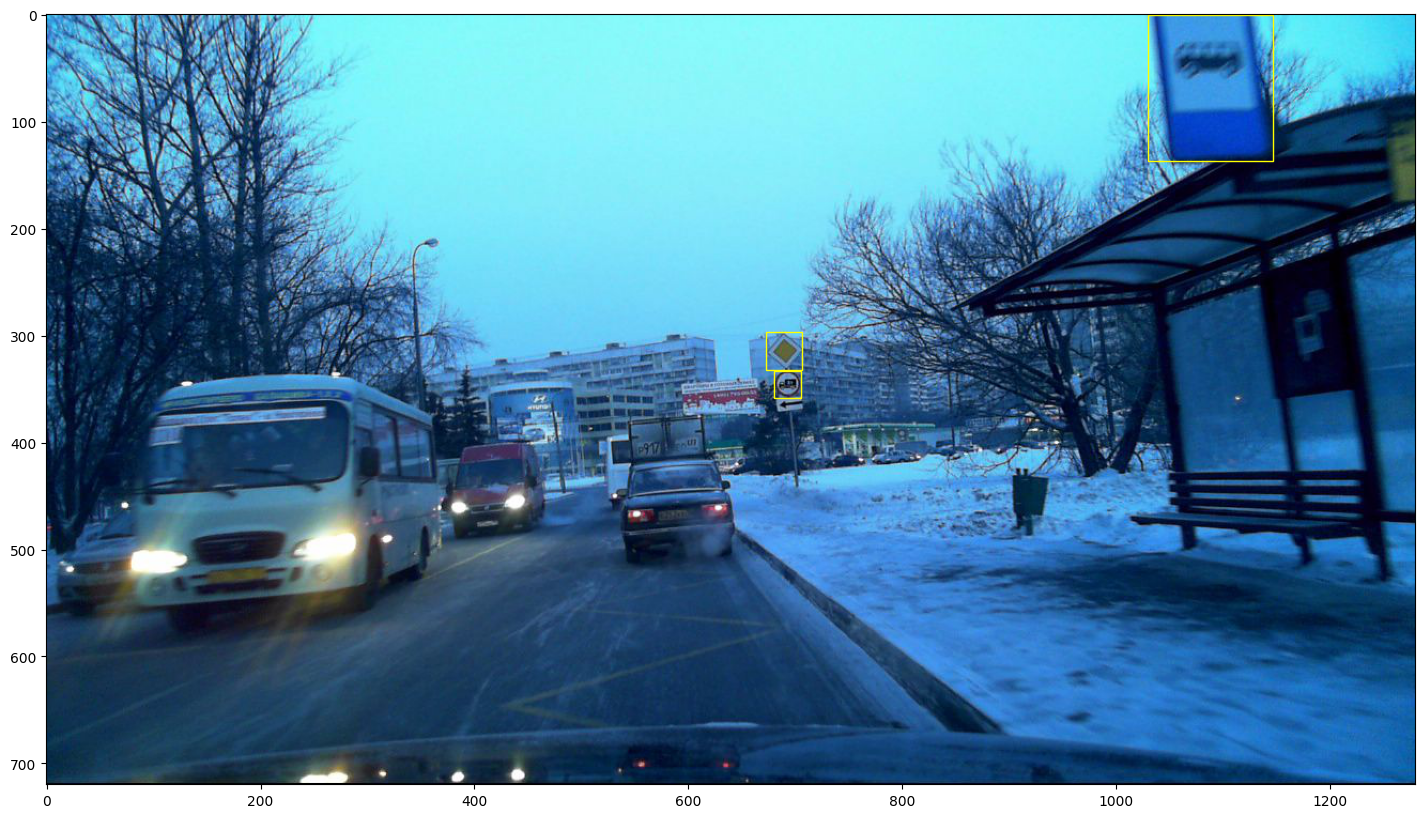

In [11]:
pycocotools_visualizer(95, [1])

In [12]:
# загрузка датасета

# The directiry containing the source images
data_path = dataset_path      # можно не указывать, если в JSON путь совпадает

# The path yo the COCO labels JSON file
labels_file = "train_anno_bin_class.json"
labels_path = os.path.join(dataset_path, labels_file)


# Import the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path
)

 100% |█████████████| 54188/54188 [1.0m elapsed, 0s remaining, 992.2 samples/s]       


In [13]:
# Визуализация набора данных
session = fo.launch_app(dataset)

In [14]:
# Использование агрегатов с помощью API для получения статистики о наборе данных
# Количество обнаружений для каждой категории
dataset.count_values("detections.detections.label")

{'sign': 95492}

In [17]:
class RTSD_dataset(Dataset):
  
    def __init__(self, json_path, img_path):
        self.json_path = json_path
        self.img_path = img_path
        
        with open(json_path, 'r') as read_file:
            self.anno = json.load(read_file)
        read_file.close()

        self.df_dataset = pd.DataFrame(self.anno.get('annotations'))
        self.test = self.df_dataset.copy()
        #self.test['bbox_for_rcnn'] = self.test.bbox[0]
        self.df_images = pd.DataFrame(self.anno.get('images'))
        self.df_images.rename(columns={'id':'image_id'}, inplace=True)
        self.df_dataset = self.df_dataset.merge(self.df_images)
        self.df_dataset = self.df_dataset[['file_name', 'bbox', 'category_id']].groupby('file_name', as_index=False).agg(list)

    def get_df(self):
        #return self.df_dataset
        return self.test

    def __len__(self):
        return self.df_dataset.shape[0]
  
    def __getitem__(self, index):
        img_name = self.df_dataset.loc[index,'file_name']
        boxes = []
        for box in self.df_dataset.loc[index,'bbox']:
            box_for_rcnn = [box[0], box[1], box[0] + box[2], box[1] + box[3]]
        boxes.append(box_for_rcnn)
        boxes = torch.Tensor(boxes).to(torch.float)            # возможно нужно преобразовать x_max и y_max
        #boxes = torch.Tensor(self.df_dataset.loc[index, 'bbox']).to(torch.float)
        labels = torch.Tensor(self.df_dataset.loc[index, 'category_id']).to(torch.int64)
        #area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 0])
        #iscrowd = torch.zeros(labels.shape[0], dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        img = cv2.imread(os.path.join(self.img_path, img_name))/255.
        img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)
        #return img, target
        return img, target

In [ ]:
#test = RTSD_dataset('data/train_anno_reduced.json', 'data/')
#test.__getitem__(0)

### Формирование батча

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

### Гиперпараметры

In [46]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
elif torch.backends.mps.is_available() == True:
    device = 'mps'
else:
    device = 'cpu'
n_epochs = 10
batch_size = 16
num_classes = 2

In [47]:
device

'mps'

### Инициализация модели, задание оптимизатора и функции потерь

In [48]:
def create_model(num_classes, pretrained=True):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [49]:
model = create_model(num_classes=2, pretrained=True).to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#ptimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

train_dataset = RTSD_dataset(os.path.join(dataset_path, 'train_anno_bin_class.json'),
                                          dataset_path)
val_dataset = RTSD_dataset(os.path.join(dataset_path, 'val_anno_bin_class.json'), dataset_path)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)

### Трейн луп

In [50]:
def train(train_dataloader): 
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tИтерация #{i} loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [55]:
train_losses = []
val_losses = []
try:
    for epoch in range(10):
        start = time.time()
        train_loss = train(train_data_loader)
        val_loss = val(val_data_loader)
        lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'loss_train': train_loss,
            'loss_val': val_loss
            }, os.path.join(dataset_path, f'./checkpoints/model_detector_resnet50_{epoch}.pth'))
except KeyboardInterrupt:
    print('Прервано пользователем')

RuntimeError: MPS backend out of memory (MPS allocated: 9.32 GB, other allocations: 8.95 GB, max allowed: 18.13 GB). Tried to allocate 256 bytes on shared pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [54]:
lr_scheduler.state_dict()

{'step_size': 3,
 'gamma': 0.1,
 'base_lrs': [0.005],
 'last_epoch': 0,
 'verbose': False,
 '_step_count': 1,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.005]}

In [ ]:
fig, ax  = plt.subplots()
ax.plot(train_losses, label='Train')
#ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()